This code will load the model information, generate the model definition, and run the model estimation using FSL

In [5]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting
sys.path.append('../utils/')
from compute_fd_dvars import compute_fd,compute_dvars

from make_event_files_from_json import MakeEventFilesFromJSON
%matplotlib inline
import matplotlib.pyplot as plt


try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
    
results_dir = os.path.abspath("../../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print('Using data from',datadir)

Using data from /home/vagrant/data


Load the scan and model info, and generate the event files for FSL from the information in model.json

In [14]:
subject='sub00001'
session='ses014'  
# note - we have to use the anatomy from a different session'
subdir=os.path.join(datadir,'ds031', subject, session)

tasknum=2 # n-back
bolddir=os.path.join(datadir,'ds031/sub00001',session,
        'functional')
boldfile=os.path.join(bolddir,
    'sub00001_ses014_task002_run001_bold.nii.gz')

preprocessed_epi = os.path.join(results_dir, 
                    "sub00001_ses014_task002_run001_bold_mcf_brain.nii.gz")

scaninfo=json.load(open(os.path.join(subdir,
        'functional/sub00001_ses014_task002_run001_bold.json')))
tr=scaninfo['RepetitionTime']

modelfile=os.path.join(subdir,'model.json')
modelinfo=json.load(open(modelfile))
taskinfo=modelinfo['task%03d'%tasknum]['model001']
evs=taskinfo['Variables']
contrasts=taskinfo['Contrasts']

# get the response onsets
response_onsets=[]

for v in evs.keys():

    if evs[v]['VariableName'].find('_target_ons')>-1:
        for ons in evs[v]['onsets']:
            response_onsets.append(ons[0])

Load the motion parameters that we created during preprocessing, so we can use them as regressors.  Also generate the framewise displacement.

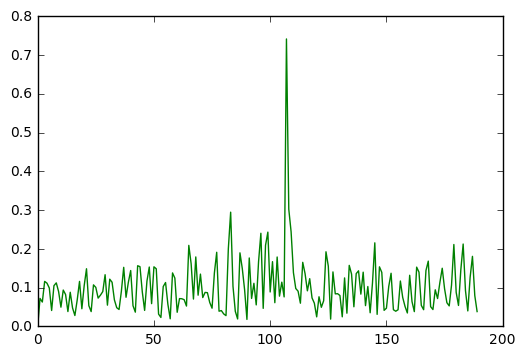

In [15]:
# First you need to set this to your mcflirt cache directory
mcpars=numpy.loadtxt(os.path.join(results_dir, "motion.par"))
fd=compute_fd(mcpars)
plt.plot(fd,color='g')

If the necessary files don't exist, then rerun preprocessing on BOLD file


In [19]:
if not os.path.exists(preprocessed_epi):
    mcflirt = mem.cache(fsl.MCFLIRT)
    mcflirt_results = mcflirt(in_file=boldfile,
                              mean_vol=True)

    boldbet = mem.cache(fsl.BET)
    bet_results = boldbet(functional=True,
                  in_file=mcflirt_results.outputs.out_file,
                  out_file=preprocessed_epi,
                  mask=True)

161014-13:56:34,334 workflow INFO:
	 Executing node fbfa00c218746e802e49f0bde8aa0174 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/fbfa00c218746e802e49f0bde8aa0174
161014-13:56:34,337 workflow INFO:
161014-13:56:34,344 workflow INFO:
	 Executing node 969038877c9f2d833607ae0287f263a8 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-BET/969038877c9f2d833607ae0287f263a8
161014-13:56:34,350 workflow INFO:
	 Running: bet /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/fbfa00c218746e802e49f0bde8aa0174/sub00001_ses014_task002_run001_bold_mcf.nii.gz /home/vagrant/fmri-analysis-vm/results/sub00001_ses014_task002_run001_bold_mcf_brain.nii.gz -F -m


Specify the model.  For the sake of speed we will use a simplified model that treats the study as a blocked design rather than modeling each item separately, but we also model instructions and motor responses; this, it is a hybrid block/event-related.


In [20]:
instruction_onsets=list(numpy.array([68,176,372,2,154,416,24,220,350,112,198,328,46,264,394,90,242,306])-2.0)

info = [Bunch(conditions=['faces-1back',
                          'faces-2back',
                          'scenes-1back',
                          'scenes-2back',
                          'chars-1back',
                          'chars-2back',
                          'instructions',
                          'responses'],
              onsets=[[68,176,372],
                      [2,154,416],
                      [24,220,350],
                      [112,198,328],
                      [46,264,394],
                      [90,242,306],
                      instruction_onsets,
                      response_onsets],
              durations=[[20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [2],
                         [1]],
            regressors=[fd],
            regressor_names=['FD'])
       ]

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = preprocessed_epi
s.inputs.time_repetition = tr
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()
s.inputs


event_files = <undefined>
functional_runs = ['/home/vagrant/fmri-analysis-vm/results/sub00001_ses014_task002_run001_bold_mcf_brain.nii.gz']
high_pass_filter_cutoff = 128.0
ignore_exception = False
input_units = secs
outlier_files = <undefined>
realignment_parameters = <undefined>
subject_info = [Bunch(conditions=['faces-1back', 'faces-2back', 'scenes-1back', 'scenes-2back', 'chars-1back', 'chars-2back', 'instructions', 'responses'], durations=[[20], [20], [20], [20], [20], [20], [2], [1]], onsets=[[68, 176, 372], [2, 154, 416], [24, 220, 350], [112, 198, 328], [46, 264, 394], [90, 242, 306], [66.0, 174.0, 370.0, 0.0, 152.0, 414.0, 22.0, 218.0, 348.0, 110.0, 196.0, 326.0, 44.0, 262.0, 392.0, 88.0, 240.0, 304.0], [60.024, 62.024, 98.023, 270.027, 400.013, 14.021, 70.011, 74.013, 160.015, 170.019, 178.022, 186.025, 374.019, 384.024, 432.027, 34.013, 36.014, 122.016, 214.02, 334.02, 362.014]], regressor_names=['FD'], regressors=[array([ 0.        ,  0.07236592,  0.06300166,  0.11626191,  

Generate the fsf and ev files using Level1Design.

__Exercise:__ add an additional T contrast for the FD variable.

In [21]:
contrasts=[['faces>Baseline','T', 
            ['faces-1back','faces-2back'],[0.5,0.5]],
           ['scenes>Baseline','T', 
            ['scenes-1back','scenes-2back'],[0.5,0.5]],
           ['chars>Baseline','T', 
            ['chars-1back','chars-2back'],[0.5,0.5]],
           ['2back>1back','T', 
            ['faces-1back','faces-2back','scenes-1back','scenes-2back','chars-1back','chars-2back'],[-1,1,-1,1,-1,1,-1,1]],
          ['response>Baseline','T',
           ['responses'],[1]],
          ['instructions>Baseline','T',
           ['instructions'],[1]]]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = tr,
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

161014-13:57:11,302 workflow INFO:
	 Executing node 5e8bf8747177d64252f8403f0098baef in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/5e8bf8747177d64252f8403f0098baef



ev_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/5e8bf8747177d64252f8403f0098baef/ev_faces-1back_0_1.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/5e8bf8747177d64252f8403f0098baef/ev_faces-2back_0_3.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/5e8bf8747177d64252f8403f0098baef/ev_scenes-1back_0_5.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/5e8bf8747177d64252f8403f0098baef/ev_scenes-2back_0_7.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/5e8bf8747177d64252f8403f0098baef/ev_chars-1back_0_9.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/5e8bf8747177d64252f8403f0098baef/ev_chars-2back_0_11.txt', '/home/vagra

Generate the full set of model files using FEATModel

In [22]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

161014-13:57:14,755 workflow INFO:
	 Executing node 4aab0385c7ccc4ed92462e1ba5c09d84 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4aab0385c7ccc4ed92462e1ba5c09d84
161014-13:57:14,760 workflow INFO:
	 Running: feat_model run0 



con_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4aab0385c7ccc4ed92462e1ba5c09d84/run0.con
design_cov = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4aab0385c7ccc4ed92462e1ba5c09d84/run0_cov.png
design_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4aab0385c7ccc4ed92462e1ba5c09d84/run0.mat
design_image = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4aab0385c7ccc4ed92462e1ba5c09d84/run0.png
fcon_file = <undefined>

Visualize the design matrix

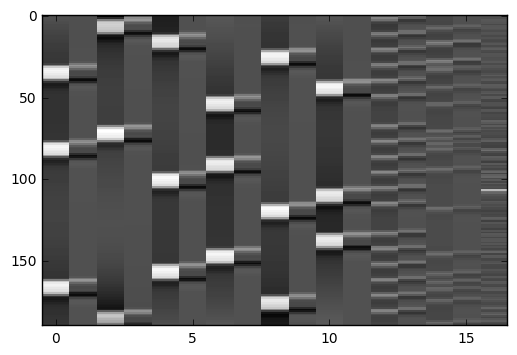

In [23]:
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

Show the correlation matrix for design

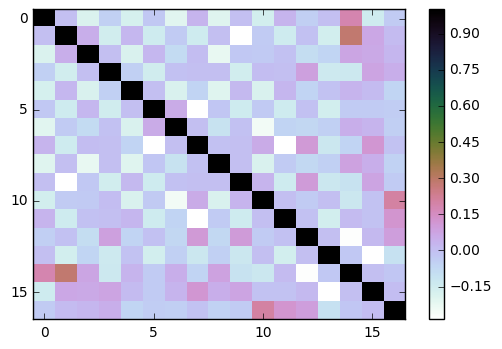

In [24]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.cubehelix_r)
plt.colorbar()

Estimate the model using FILMGLS - this will take a few minutes.

In [25]:
mask = mem.cache(fsl.maths.ApplyMask)
mask_results = mask(in_file=preprocessed_epi,
                    mask_file=os.path.join(results_dir, "mask.nii.gz"))
mask_results.outputs

161014-13:57:30,65 workflow INFO:
	 Executing node e530d7a11bc64b26d31904692901b4ed in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/e530d7a11bc64b26d31904692901b4ed
161014-13:57:30,71 workflow INFO:
	 Running: fslmaths /home/vagrant/fmri-analysis-vm/results/sub00001_ses014_task002_run001_bold_mcf_brain.nii.gz -mas /home/vagrant/fmri-analysis-vm/results/mask.nii.gz /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/e530d7a11bc64b26d31904692901b4ed/sub00001_ses014_task002_run001_bold_mcf_brain_masked.nii.gz



out_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/e530d7a11bc64b26d31904692901b4ed/sub00001_ses014_task002_run001_bold_mcf_brain_masked.nii.gz

In [26]:
filmgls= mem.cache(fsl.FILMGLS)
filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          autocorr_noestimate = True)
filmgls_results.outputs

161014-13:57:44,605 workflow INFO:
	 Executing node 3ea0667ddda4e718f21ed2b703584699 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/3ea0667ddda4e718f21ed2b703584699
161014-13:57:44,610 workflow INFO:
	 Running: film_gls --noest --rn=results --con=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4aab0385c7ccc4ed92462e1ba5c09d84/run0.con --in=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/e530d7a11bc64b26d31904692901b4ed/sub00001_ses014_task002_run001_bold_mcf_brain_masked.nii.gz --pd=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4aab0385c7ccc4ed92462e1ba5c09d84/run0.mat --thr=0.000000
161014-13:57:44,658 interface INFO:
	 stdout 2016-10-14T13:57:44.658724:Log directory is: results
161014-13:57:50,295 interface INFO:
	 stdout 2016-10-14T13:57:50.295648:paradigm.getDesignMatr


copes = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/3ea0667ddda4e718f21ed2b703584699/results/cope1.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/3ea0667ddda4e718f21ed2b703584699/results/cope2.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/3ea0667ddda4e718f21ed2b703584699/results/cope3.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/3ea0667ddda4e718f21ed2b703584699/results/cope4.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/3ea0667ddda4e718f21ed2b703584699/results/cope5.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/3ea0667ddda4e718f21ed2b703584699/results/cope6.nii.gz']
dof_file = /home/vagrant/fmri-analysis-vm/analysis/firstleve

__Exercise:__ Visualize the statistical map for the contrast that tests for effects of the motion variable (FD).

## Move copes, varcopes, and the mask into MNI space

For the group level analysis we need to move results from all subjects into one common MNI space. Let's start with the EPI derived mask (we will use it later for group level mask)

161014-14:12:39,675 workflow INFO:
	 Executing node f802a0a932632113f31ad55c8ddb2ad8 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/f802a0a932632113f31ad55c8ddb2ad8
161014-14:12:39,680 workflow INFO:
	 Running: applywarp --in=/home/vagrant/fmri-analysis-vm/results/mask.nii.gz --ref=/home/vagrant/data/ds031/sub00001/ses018/anatomy/sub00001_ses018_T1w_001.nii.gz --out=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/f802a0a932632113f31ad55c8ddb2ad8/mask_warp.nii.gz --warp=/home/vagrant/fmri-analysis-vm/results/epi_to_t1_warp.nii.gz --interp=nn
161014-14:12:54,214 workflow INFO:
	 Executing node 8cb1b0e25748e06ca05ce54265ed37ea in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/8cb1b0e25748e06ca05ce54265ed37ea
161014-14:12:54,220 workflow INFO:
	 Running: antsApplyTransforms --default-value 0 --input 

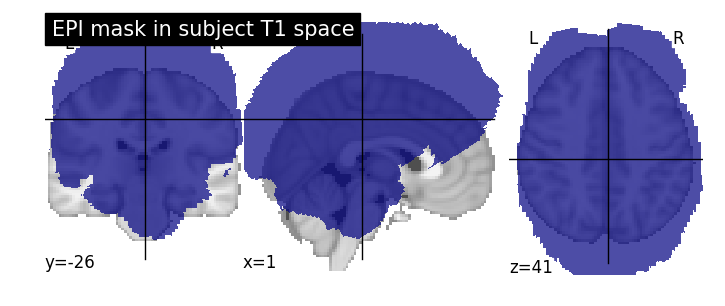

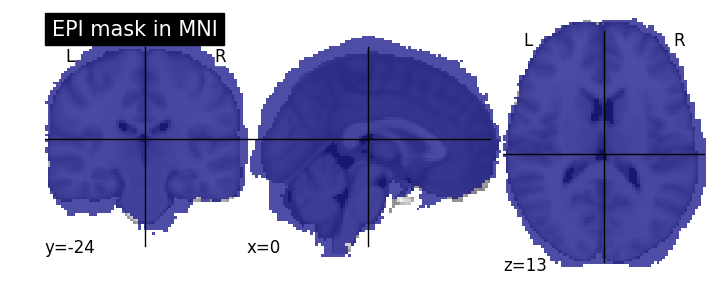

In [27]:
mask_file = os.path.join(results_dir, "mask.nii.gz")
epi_to_t1_warp = os.path.join(results_dir, "epi_to_t1_warp.nii.gz")
t1_to_mni_warp = os.path.join(results_dir, "t1_to_mni_warp.h5")
in_file = mask_file
anat_subject='ses018'
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1_file = os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')

epi_to_t1 = mem.cache(fsl.ApplyWarp)
epi_to_t1_mask_results = epi_to_t1(in_file=in_file,
                                   ref_file=t1_file,
                                   field_file=epi_to_t1_warp,
                                   interp="nn")
nilearn.plotting.plot_roi(epi_to_t1_mask_results.outputs.out_file, title="EPI mask in subject T1 space")

t1_to_mni = mem.cache(ants.ApplyTransforms)
t1_to_mni_mask_results = t1_to_mni(input_image=epi_to_t1_mask_results.outputs.out_file,
                                   reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                   transforms=t1_to_mni_warp,
                                   interpolation="NearestNeighbor")
t1_to_mni_mask_results.outputs
nilearn.plotting.plot_roi(t1_to_mni_mask_results.outputs.output_image, title="EPI mask in MNI")

Now we can use the same procedure for all of the contrast and variance images.

161014-14:12:56,875 workflow INFO:
	 Executing node f3d7bff3dd6a93cdf38bd35750889c05 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/f3d7bff3dd6a93cdf38bd35750889c05
161014-14:12:56,880 workflow INFO:
	 Running: applywarp --in=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/3ea0667ddda4e718f21ed2b703584699/results/cope1.nii.gz --ref=/home/vagrant/data/ds031/sub00001/ses018/anatomy/sub00001_ses018_T1w_001.nii.gz --out=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/f3d7bff3dd6a93cdf38bd35750889c05/cope1_warp.nii.gz --warp=/home/vagrant/fmri-analysis-vm/results/epi_to_t1_warp.nii.gz --interp=spline
161014-14:13:12,764 workflow INFO:
	 Executing node 933a4a87016c6c73fbee1e1dcb536519 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/933a4a87016c6c73fbe

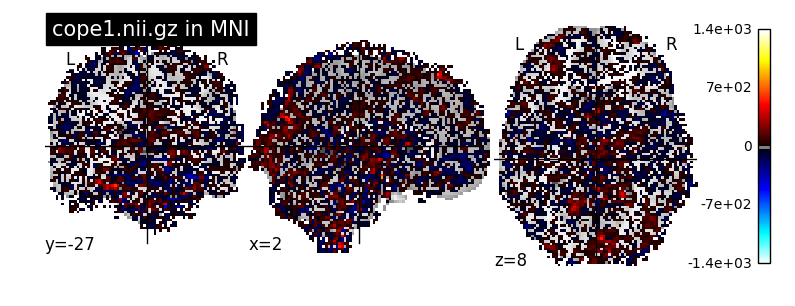

In [28]:
image=filmgls_results.outputs.copes[0]
_, fname = os.path.split(image)
epi_to_t1_results = epi_to_t1(in_file=filmgls_results.outputs.copes[0],
                                   ref_file=t1_file,
                                   field_file=epi_to_t1_warp,
                                   interp="spline")

t1_to_mni_results = t1_to_mni(input_image=epi_to_t1_results.outputs.out_file,
                              reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                              transforms=t1_to_mni_warp,
                              interpolation="BSpline")

nilearn.plotting.plot_stat_map(t1_to_mni_results.outputs.output_image, 
                        title="%s in MNI"%fname, threshold='auto')